In [23]:
#!/usr/bin/env python
# coding: utf-8
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef

## Model

In [6]:
###############################
###    Load data            ###
###############################

data_list = []
target_list = []

import glob
for fp in glob.glob("data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    
    data_list.append(data)
    target_list.append(targets)
print(data_list)

# Note:
# Choose your own training and val set based on data_list and target_list
# Here using the last partition as val set

X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_val = np.concatenate(data_list[-1: ])
y_val = np.concatenate(target_list[-1: ])
nsamples, nx, ny = X_val.shape
print("val set shape:", nsamples,nx,ny)

p_neg = len(y_train[y_train == 1])/len(y_train)*100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1])/len(y_val)*100
print("Percent positive samples in val:", p_pos)

# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device (CPU/GPU):", device)
#device = torch.device("cpu")


[array([[[ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.27371e+02,
         -4.05660e+01,  5.54000e-01],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.27371e+02,
         -4.05660e+01,  5.54000e-01],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.27371e+02,
         -4.05660e+01,  5.54000e-01],
        ...,
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
          0.00000e+00,  0.00000e+00],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
          0.00000e+00,  0.00000e+00],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
          0.00000e+00,  0.00000e+00]],

       [[ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.28450e+02,
         -4.13520e+01,  3.24000e-01],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.28450e+02,
         -4.13520e+01,  3.24000e-01],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.28450e+02,
         -4.13520e+01,  3.24000e-01],
        ...,

Training set shape: 4180 420 54
val set shape: 1526 420 54
Percent positive samples in train: 25.0
Percent positive samples in val: 24.901703800786372

NOTE:
Setting batch-size to 64
Using device (CPU/GPU): cpu


In [8]:

all_negative = []
for i in range(len(X_val)):
    all_negative.append(pd.DataFrame(X_val[i]).loc[:, 27:])
  
negative_aa = pd.concat(all_negative)
negative_aa['type'] = 0

all_positive = []
for i in range(len(X_train)):
    all_positive.append(pd.DataFrame(X_train[i]).loc[:, 27:])
  
positive_aa = pd.concat(all_positive)
positive_aa['type'] = 1

combined_aa = pd.concat([negative_aa, positive_aa])
combined_aa = combined_aa.filter(like = "400", axis=0)

In [9]:
combined_aa.rename(columns = {27:"foldx_MP", 28:'foldx_MA',
                              29:'foldx_MB', 30:'foldx_PA',
                              31:'foldx_PB', 32:'foldx_AB',
                              33:'global_complex_total_score', 34:'global_complex_fa_atr',
                              35:'global_complex_fa_dun', 36:'global_complex_fa_elec',
                              37:'global_complex_fa_rep', 38:'global_complex_fa_sol',
                              39:'global_complex_p_aa_pp', 40:'global_tcr_total_score',
                              41:'global_tcr_fa_atr', 42:'global_tcr_fa_dun',
                              43:'global_tcr_fa_elec', 44:'global_tcr_fa_rep',
                              45:'global_tcr_fa_sol', 46:'global_tcr_p_aa_pp',
                              47:'global_pmhc_total_score', 48:'global_pmhc_total_score',
                              49:'global_pmhc_fa_dun', 50:'global_pmhc_fa_elec',
                              51:'global_pmhc_fa_rep', 52:'global_pmhc_fa_sol',
                              53:'global_pmhc_p_aa_pp'}, inplace = True)

display(combined_aa)

,foldx_MP,foldx_MA,foldx_MB,foldx_PA,foldx_PB,foldx_AB,global_complex_total_score,global_complex_fa_atr,global_complex_fa_dun,global_complex_fa_elec,...,global_tcr_fa_sol,global_tcr_p_aa_pp,global_pmhc_total_score,global_pmhc_total_score,global_pmhc_fa_dun,global_pmhc_fa_elec,global_pmhc_fa_rep,global_pmhc_fa_sol,global_pmhc_p_aa_pp,type
400,-5.31471,-0.018750,-1.579060,0.000000,-1.114660,-1.221790,-1198.017,489.407,-716.398,4.547,...,-49.781,2.017,-564.837,235.900,-369.030,2.223,730.223,-36.813,0.562,0
400,-4.24159,-0.028706,-1.218520,0.000000,-0.472663,-1.760200,-1193.899,485.547,-727.601,4.563,...,-45.611,2.160,-555.241,241.013,-359.068,2.267,721.548,-39.600,0.599,0
400,-5.24027,-0.087604,-1.113920,0.000000,-1.126730,-2.001180,-1165.557,507.476,-720.916,4.698,...,-58.510,2.827,-563.260,237.391,-366.161,2.242,728.364,-47.355,0.692,0
400,-5.12103,-0.026745,-1.350520,0.000000,-0.773870,-1.195500,-1158.215,501.414,-703.617,4.608,...,-40.378,1.629,-571.231,240.097,-373.633,2.184,735.222,-42.991,0.381,0
400,-5.39294,-0.012788,-0.718076,0.000000,-0.567439,-3.367160,-1167.533,494.376,-726.102,4.544,...,-45.711,2.103,-568.711,235.445,-372.490,2.175,732.663,-43.746,0.388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,-5.75444,-1.060510,-2.272270,0.000000,-0.041398,-0.654751,-1142.403,514.077,-748.952,4.629,...,-49.604,1.449,-539.671,244.749,-367.975,2.185,746.538,-41.987,0.428,1
400,-4.62376,-0.114288,-3.353050,-0.777817,-0.562722,-2.385220,-1191.775,480.316,-729.325,4.766,...,-48.551,1.663,-554.171,241.403,-364.546,2.243,721.822,-38.542,0.266,1
400,-5.84560,-0.215960,-0.992221,0.000000,0.000000,-0.724675,-1182.122,503.397,-717.804,4.776,...,-47.835,2.128,-553.938,236.854,-371.508,2.145,745.758,-43.875,0.413,1
400,-4.89419,-1.094790,-1.434680,-0.663445,-1.505460,-3.029970,-1162.975,519.913,-762.341,4.946,...,-54.325,1.898,-571.135,237.498,-366.944,2.162,719.285,-45.104,0.334,1


In [12]:
smote = SMOTE(random_state=77)
print(combined_aa.keys())
X_resamp, y_resamp=smote.fit_resample(np.array(combined_aa.loc[:,combined_aa.columns!="type"]),np.array(combined_aa["type"]))
print(format(X_resamp.shape))
print(format(y_resamp.shape))

#Split and train data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_resamp, y_resamp, test_size=0.2, random_state=77)


Index(['foldx_MP', 'foldx_MA', 'foldx_MB', 'foldx_PA', 'foldx_PB', 'foldx_AB',
       'global_complex_total_score', 'global_complex_fa_atr',
       'global_complex_fa_dun', 'global_complex_fa_elec',
       'global_complex_fa_rep', 'global_complex_fa_sol',
       'global_complex_p_aa_pp', 'global_tcr_total_score', 'global_tcr_fa_atr',
       'global_tcr_fa_dun', 'global_tcr_fa_elec', 'global_tcr_fa_rep',
       'global_tcr_fa_sol', 'global_tcr_p_aa_pp', 'global_pmhc_total_score',
       'global_pmhc_total_score', 'global_pmhc_fa_dun', 'global_pmhc_fa_elec',
       'global_pmhc_fa_rep', 'global_pmhc_fa_sol', 'global_pmhc_p_aa_pp',
       'type'],
      dtype='object')
(8360, 27)
(8360,)
[[-4.56307000e+00 -1.54806000e+00 -1.90378000e-01 ...  7.32480000e+02
  -4.80170000e+01  3.74000000e-01]
 [-4.12473000e+00 -4.92429000e-01 -4.32695000e+00 ...  7.42192000e+02
  -4.33760000e+01  5.90000000e-01]
 [-5.05894000e+00 -1.77285000e+00 -1.01750000e+00 ...  7.51338000e+02
  -4.31540000e+01  2.04000

In [15]:
#Train and fit Logistic Regression model.
LoRmod=LogisticRegression(max_iter=10000)
LoRmod.fit(X_train_new, y_train_new)
#Score LR training
LoRmod.score(X_train_new, y_train_new)

#Predict from manufactured test and score
LoRpred= LoRmod.predict(X_test_new)
print('Accuracy score:', accuracy_score(y_test_new,LoRpred)*100)
print('F1 score:', f1_score(y_test_new, LoRpred)*100)
print('Recall score:', recall_score(y_test_new, LoRpred)*100)
print('Precision score:', precision_score(y_test_new, LoRpred)*100)
print('Confusion matrix:', confusion_matrix(y_test_new, LoRpred))
print('Classification report:', classification_report(y_test_new, LoRpred))

Accuracy score: 52.39234449760766
F1 score: 50.187734668335416
Recall score: 48.19711538461539
Precision score: 52.34986945169713
Confusion matrix: [[475 365]
 [431 401]]
Classification report:               precision    recall  f1-score   support

           0       0.52      0.57      0.54       840
           1       0.52      0.48      0.50       832

    accuracy                           0.52      1672
   macro avg       0.52      0.52      0.52      1672
weighted avg       0.52      0.52      0.52      1672



In [16]:
#Train and fit Decesion tree model.
DTmod=DecisionTreeClassifier(criterion='gini', random_state = 77,max_depth=10)
DTmod.fit(X_train_new,y_train_new)
#Score DT fit.
DTmod.score(X_train_new, y_train_new)
#Predict from manufactured test and score
DTpred = DTmod.predict(X_test_new)
print('Accuracy score:', accuracy_score(y_test_new,DTpred)*100)
print('F1 score:', f1_score(y_test_new, DTpred)*100)
print('Recall score:', recall_score(y_test_new, DTpred)*100)
print('Precision score:', precision_score(y_test_new, DTpred)*100)
print('Confusion matrix:', confusion_matrix(y_test_new, DTpred))
print('Classification report:', classification_report(y_test_new, DTpred))

Accuracy score: 62.32057416267942
F1 score: 58.49802371541502
Recall score: 53.36538461538461
Precision score: 64.72303206997084
Confusion matrix: [[598 242]
 [388 444]]
Classification report:               precision    recall  f1-score   support

           0       0.61      0.71      0.65       840
           1       0.65      0.53      0.58       832

    accuracy                           0.62      1672
   macro avg       0.63      0.62      0.62      1672
weighted avg       0.63      0.62      0.62      1672



ValueError: The number of FixedLocator locations (27), usually from a call to set_ticks, does not match the number of ticklabels (28).

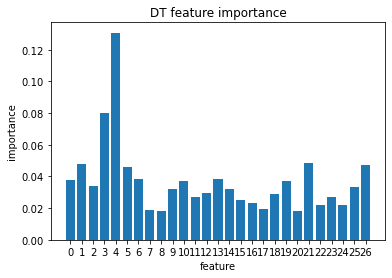

In [27]:
#Determine how RF weighted features.
featurelist=list(combined_aa.columns[:])
plt.bar(range(len(DTmod.feature_importances_)), DTmod.feature_importances_)
plt.xlabel("feature")
plt.ylabel("importance")
plt.title("DT feature importance")
plt.xticks(range(len(DTmod.feature_importances_)), featurelist,rotation='vertical')
plt.show()
print(featurelist)

In [19]:
#Train and fit Random Forest model.
RFmod=RandomForestClassifier(n_estimators=100,random_state=77)
RFmod.fit(X_train_new,y_train_new)
#Score RF fit.
RFmod.score(X_train_new, y_train_new)

#Predict from manufactured test and score
RFpred = RFmod.predict(X_test_new)
print('Accuracy score:', accuracy_score(y_test_new,RFpred)*100)
print('F1 score:', f1_score(y_test_new, RFpred)*100)
print('Recall score:', recall_score(y_test_new, RFpred)*100)
print('Precision score:', precision_score(y_test_new, RFpred)*100)
print('Confusion matrix:', confusion_matrix(y_test_new, RFpred))
print('Classification report:', classification_report(y_test_new, RFpred))

Accuracy score: 79.78468899521532
F1 score: 80.14101057579317
Recall score: 81.97115384615384
Precision score: 78.39080459770115
Confusion matrix: [[652 188]
 [150 682]]
Classification report:               precision    recall  f1-score   support

           0       0.81      0.78      0.79       840
           1       0.78      0.82      0.80       832

    accuracy                           0.80      1672
   macro avg       0.80      0.80      0.80      1672
weighted avg       0.80      0.80      0.80      1672



ValueError: The number of FixedLocator locations (27), usually from a call to set_ticks, does not match the number of ticklabels (28).

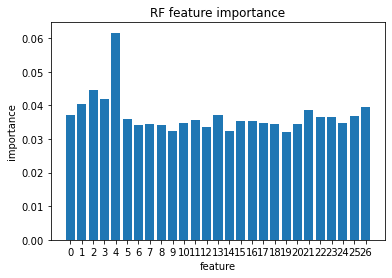

In [26]:
#Determine how RF weighted features.
featurelist=list(combined_aa.columns[:])
plt.bar(range(len(RFmod.feature_importances_)), RFmod.feature_importances_)
plt.xlabel("feature")
plt.ylabel("importance")
plt.title("RF feature importance")
plt.xticks(range(len(RFmod.feature_importances_)), featurelist,rotation='vertical')
plt.show()
print(featurelist)

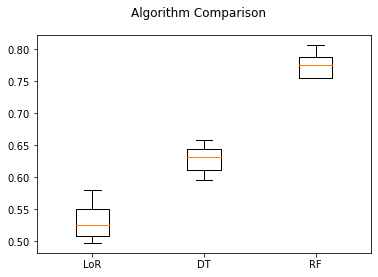

In [21]:
kfold = model_selection.KFold(n_splits=10)
cv_LoR = model_selection.cross_val_score(LogisticRegression(max_iter=10000), X_train_new, y_train_new, cv=kfold, scoring='accuracy')
cv_DT = model_selection.cross_val_score(DecisionTreeClassifier(criterion='gini', random_state = 77,max_depth=11), X_train_new, y_train_new, cv=kfold, scoring='accuracy')
cv_RF = model_selection.cross_val_score(RandomForestClassifier(n_estimators=100), X_train_new, y_train_new, cv=kfold, scoring='accuracy')
results=[cv_LoR,cv_DT,cv_RF]
names=["LoR","DT","RF"]
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [24]:
print("MCC Train:", matthews_corrcoef(X_train_new, y_train_new), "MCC val:", matthews_corrcoef(X_test_new, y_test_new))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [ ]:
smote = SMOTE(random_state=77)
print(combined_aa.keys())
X_resamp, y_resamp=smote.fit_resample(np.array(combined_aa.loc[:,combined_aa.columns!="type"]),np.array(combined_aa["type"]))
print(format(X_resamp.shape))
print(format(y_resamp.shape))

In [ ]:
#Split and train data
X_train, X_test, y_train, y_test = train_test_split(X_resamp, y_resamp, test_size=0.2, random_state=77)

## MH

# Helpful scripts

# Show dataset as copied dataframes with named features
The dataset is a 3D numpy array, of dimensions n_complexes x features x positions. This makes viewing the features for individual complexes or samples challenging. Below is a function which copies the entire dataset, and converts it into a list of DataFrames with named indices and columns, in order to make understanding the data easier.

NB: This list of dataframes are only copies, and will not be passable into the neural network architecture.

In [ ]:
def copy_as_dataframes(dataset_X):
    """
    Returns list of DataFrames with named features from dataset_X,
    using example CSV file
    """
    df_raw = pd.read_csv("data/example.csv")
    return [pd.DataFrame(arr, columns = df_raw.columns) for arr in dataset_X]

named_dataframes = copy_as_dataframes(X_train)
print("Showing first complex as dataframe. Columns are positions and indices are calculated features")

named_dataframes[0]

In [ ]:
named_dataframes[0].loc[:, 'per_res_fa_atr':'foldx_MP']

# View complex MHC, peptide and TCR alpha/beta sequences
You may want to view the one-hot encoded sequences as sequences in single-letter amino-acid format. The below function will return the TCR, peptide and MHC sequences for the dataset as 3 lists.

In [ ]:
def oneHot(residue):
    """
    Converts string sequence to one-hot encoding
    Example usage:
    seq = "GSHSMRY"
    oneHot(seq)
    """
    
    mapping = dict(zip("ACDEFGHIKLMNPQRSTVWY", range(20)))
    if residue in "ACDEFGHIKLMNPQRSTVWY":
        return np.eye(20)[mapping[residue]]
    else:
        return np.zeros(20)
def reverseOneHot(encoding):
    """
    Converts one-hot encoded array back to string sequence
    """
    mapping = dict(zip(range(20),"ACDEFGHIKLMNPQRSTVWY"))
    seq=''
    for i in range(len(encoding)):
        if np.max(encoding[i])>0:
            seq+=mapping[np.argmax(encoding[i])]
    return seq

def extract_sequences(dataset_X):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    mhc_sequences = [reverseOneHot(arr[0:179,0:20]) for arr in dataset_X]
    pep_sequences = [reverseOneHot(arr[179:190,0:20]) for arr in dataset_X]
    tcr_sequences = [reverseOneHot(arr[192:,0:20]) for arr in dataset_X]
    df_sequences = pd.DataFrame({"MHC":mhc_sequences, "peptide":pep_sequences,
                                 "tcr":tcr_sequences})
    return df_sequences

In [ ]:
complex_sequences = extract_sequences(X_val)
print("Showing MHC, peptide and TCR alpha/beta sequences for each complex")
complex_sequences

In [ ]:
complex_sequences = extract_sequences(X_train)
print("Showing MHC, peptide and TCR alpha/beta sequences for each complex")
complex_sequences

In [ ]:
complex_sequences.to_csv('out.csv')

In [ ]:
for (index_label, row_series) in complex_sequences.iterrows():
    this_string = ""
    make_file = open("these_fasta_" + str(index_label) + ".txt", "w")
    this_string = ">a\nKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPELIMFIYSNGDKEDGRFTAQLNKASQYISLLIRDSKLSDSATYLCAVRTNSGYALNFGKGTSLLVTPHIQKPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKCVLDMRSMDFKSNSAVAWSNKSDFACANAFNNSIIPEDTFFPSP\n>b\n" + row_series.values[2] + "\n>c\n"  + row_series.values[1] + "\n>d\n" + row_series.values[0] 
    make_file.write(this_string)
    make_file.close()

In [ ]:
for (index_label, row_series) in complex_sequences.iterrows():
    this_string = ""
    make_file = open("these_fasta_" + str(index_label + 1523) + ".txt", "w")
    this_string = ">a\nKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPELIMFIYSNGDKEDGRFTAQLNKASQYISLLIRDSKLSDSATYLCAVRTNSGYALNFGKGTSLLVTPHIQKPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKCVLDMRSMDFKSNSAVAWSNKSDFACANAFNNSIIPEDTFFPSP\n>b\n" + row_series.values[2] + "\n>c\n"  + row_series.values[1] + "\n>d\n" + row_series.values[0] 
    make_file.write(this_string)
    make_file.close()